# Preprocessing Data & Finding Optimal K for K-Means

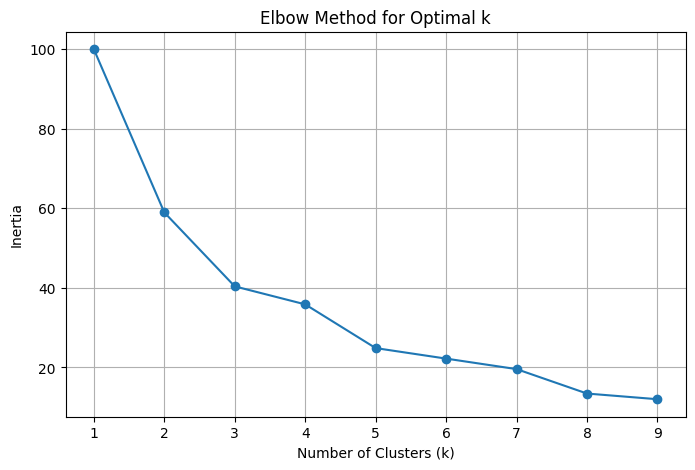

In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("typing_sessions.csv")

user_data = df.groupby("User_ID")[["WPM", "Accuracy"]].mean().reset_index()

# Normalize data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(user_data[["WPM", "Accuracy"]])

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


Based on this graph, it looks like the optimal k value is 3

# K-Means Model Building

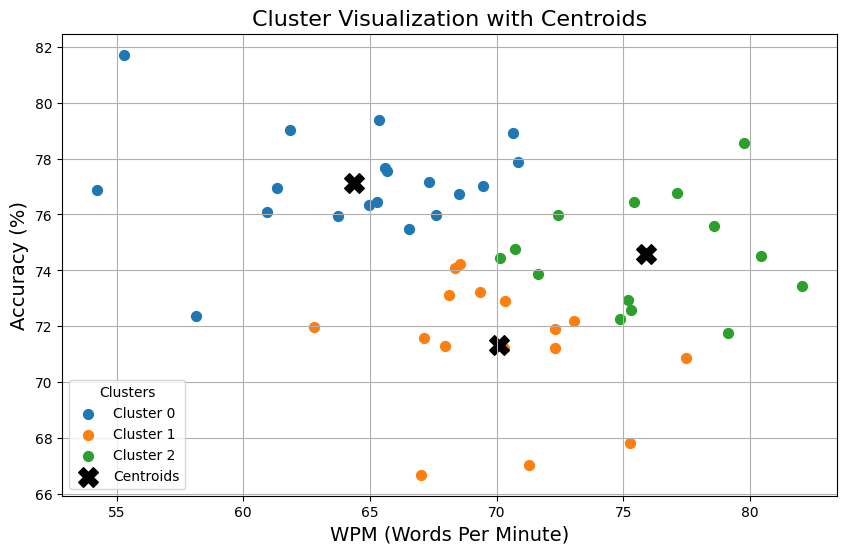

In [2]:
optimal_k = 3  
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42)
user_data['Cluster'] = kmeans_model.fit_predict(normalized_data)

# Extract cluster centroids and inverse transform to original scale for visualization
centroids = scaler.inverse_transform(kmeans_model.cluster_centers_)

# Scatter plot for clusters with centroids
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    cluster_data = user_data[user_data['Cluster'] == cluster]
    plt.scatter(cluster_data['WPM'], cluster_data['Accuracy'],
                label=f'Cluster {cluster}', s=50)
    
# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], 
            color='black', marker='X', s=200, label='Centroids')

# Add labels and title
plt.title("Cluster Visualization with Centroids", fontsize=16)
plt.xlabel("WPM (Words Per Minute)", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.legend(title="Clusters")
plt.grid(True)
plt.show()


## K-Means Details

         WPM   Accuracy  Cluster
0  64.379148  77.131274        0
1  70.098968  71.342111        1
2  75.914355  74.571022        2
Cluster
0    19
1    16
2    15
Name: count, dtype: int64


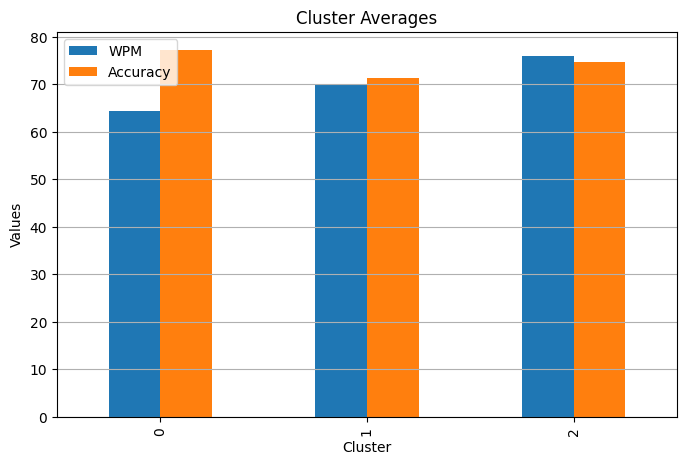

Cluster 0:
  - Avg WPM: 64.38
  - Avg Accuracy: 77.13

Cluster 1:
  - Avg WPM: 70.10
  - Avg Accuracy: 71.34

Cluster 2:
  - Avg WPM: 75.91
  - Avg Accuracy: 74.57



In [3]:
centroids_original = scaler.inverse_transform(kmeans_model.cluster_centers_)

centroids_df = pd.DataFrame(centroids_original, columns=["WPM", "Accuracy"])
centroids_df["Cluster"] = range(optimal_k)
print(centroids_df)

cluster_sizes = user_data['Cluster'].value_counts().sort_index()
print(cluster_sizes)

cluster_summary = user_data.groupby("Cluster")[["WPM", "Accuracy"]].mean()

cluster_summary.plot(kind="bar", figsize=(8, 5), title="Cluster Averages")
plt.xlabel("Cluster")
plt.ylabel("Values")
plt.grid(axis='y')
plt.show()

for cluster_id, row in centroids_df.iterrows():
    print(f"Cluster {cluster_id}:")
    print(f"  - Avg WPM: {row['WPM']:.2f}")
    print(f"  - Avg Accuracy: {row['Accuracy']:.2f}")
    print()

# Random Forest Model 

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] 

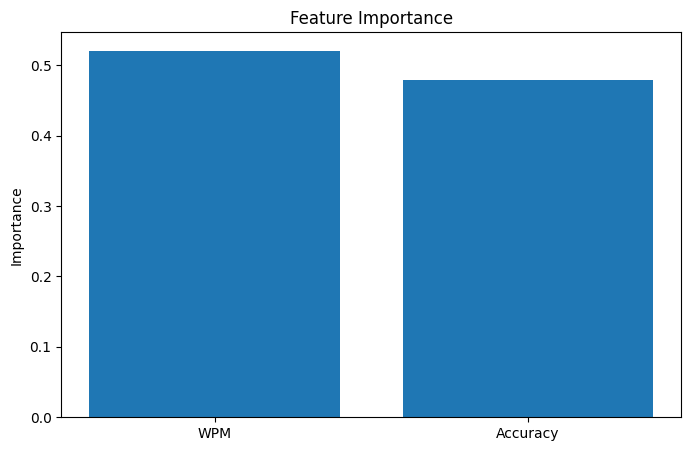

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

X = user_data[["WPM", "Accuracy"]]
y = user_data["Cluster"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid_refined = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_refined, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Best Refined Parameters: {best_params}")
print(f"Best Refined Cross-Validation Accuracy: {best_score:.2f}")
print(f"Refined Test Set Accuracy: {accuracy:.2f}")

importances = best_rf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(8, 5))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance")
plt.show()

### Export RF Model

In [6]:
import joblib

joblib.dump(best_rf, "random_forest_model.pkl")

loaded_model = joblib.load("random_forest_model.pkl")
predictions = loaded_model.predict(X_test)


### Tests

In [7]:
best_rf_refined = joblib.load("random_forest_model.pkl")

new_data = pd.DataFrame({
    "WPM": [55, 80, 45],
    "Accuracy": [85.0, 60.0, 90.0]
})

predicted_clusters = best_rf_refined.predict(new_data)

new_data["Predicted_Cluster"] = predicted_clusters
print(new_data)


   WPM  Accuracy  Predicted_Cluster
0   55      85.0                  0
1   80      60.0                  1
2   45      90.0                  0
